<a href="https://colab.research.google.com/github/jannickk/alloy-databricks/blob/main/Customer_Journey_Proteomics_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup of Python Environment

## Instalation of Client Package

massflows provides you with a client package which handles a lot of low level code for you so that you can focus on getting results.
This package is publicly available on PyPi (https://pypi.org/project/mass-iq/). You can use the below command to install the package in your enviornment.

In [ ]:
%pip install mass-iq==1.0.0

## Import python libraries

Import all relevant libraries for this notebook

In [ ]:
from io import BytesIO
import requests
from pathlib import Path
import gzip
from io import BytesIO
import shutil
from ftplib import FTP
import re
import concurrent
import os
from pathlib import Path
import pandas as pd
import json


# API Access and Client Instantiation


## User Sign Up

Your environment is be parameterized by two variables, i.e. DOMAIN and the SERVICE_PORT. Massflows will provide you with these values. Once you have both the Domain and the service port you can self-register for the mass-iq API. This will only be possible when you received an invitation Email from massflows and you were successfully onboarded. If you already accepted the Invitation, you can you the following link:

https://\<YOUR DOMAIN>:\<YOUR SERVICE PORT>/api/v1/entraid/sign-up


## Client object creation

In order to interact with the massIQ API, you can either use the REST API directly or you use the higher level functions of the client classs that ships with the mass-iq package. The client object is parameterized by the following variables:

    "USER_APP_CLIENT_ID"
    "USER_APP_CLIENT_SECRET"
    "DOMAIN"
    "SERVICE_PORT"
    
  You must provide these as environmental variables as the Client object is completely configured through the environment. If anything is missing in the environment, an error will be thrown when you try to configure it.

  The following examples code fetches the values from the Colaboratory User Data and sets them as environmental variables

In [ ]:
# Construct an client object

import os
from mass_iq.client.Client import Client
from google.colab import userdata

variables=[
            "USER_APP_CLIENT_ID",
            "USER_APP_CLIENT_SECRET",
            "DOMAIN",
            "SERVICE_PORT"
           ]

for variable in variables:
# Transfer user data secrets into environmental variables
  os.environ[variable] = userdata.get(variable)

client = Client()

This is an alternative way if you don't fetch the data from some external keyvault

In [ ]:
# If you need to set environmental varaibles directly, you need to do it in the following way

import os
from mass_iq.client.Client import Client

os.environ["USER_APP_CLIENT_ID"]="<CLIENT ID>"
os.environ["USER_APP_CLIENT_SECRET"]="<CLIENT SECRET>"
os.environ["DOMAIN"]="ibt078.ibt.kfa-juelich.de"
os.environ["SERVICE_PORT"]="30007"


client = Client()

# Library upload and Queries

## Download local copy of pubicly available mzIdentML file (if you don't have own files)

If you don't have own mzIdentML files, we download a publicly available example mzIdentML file from Github for demonstration purposes. It is an example library from the HUPO-PSI Github repository.



In [ ]:


url = "https://github.com/HUPO-PSI/mzIdentML/raw/refs/heads/master/examples/1_2examples/PeptideShaker_mzid_1_2_example/PeptideShaker_mzid_1_2_example.mzid.gz"


file_path = Path("PeptideShaker_mzid_1_2_example.mzid")

# download and decompress directly to disk
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with gzip.open(r.raw, "rb") as gz:
        with open(file_path, "wb") as out_file:
            shutil.copyfileobj(gz, out_file)


## Upload to massIQ API using high-level functions

Now that we have a local copy of the publicly available mzIdentML file, we can upload it to the massflows API using the "upload_library" function of the client object.

This function takes the path of the mzMLident file in your local filesystem and a 'user_defined_path' argument. This is essentially the path in your home directory. The path must be POSIX-compliant relative path, i.e. use forward slashes. Overall in your path you can use the following characters and you must not exceed 255 characters in any path segment



               Allowed characters: letters, digits, '-', '_', '.'
                        Each segment must be 1–255 chars

In [ ]:


## If you are on Windows, copy the path of the file and paste it here and precede the string with "r". telling python to not interpret the backward slashes as escape character
local_path=Path(r"C:\Users\<YOUR WINDOWS USER>\<YOUR PATH>\<PATH ELEMENT>")

## If you are on a Linux or Mac, your local path will use forward slashes
local_path= Path("/content/Coryne_only_10_proteins_2.mzid")

## Here your just specify a directory to the file
user_defined_path="This/is/your/custom/path/inside/your/home/directory"

client.upload_library_files(local_path, user_defined_path)




Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/libraries?user_defined_path=This%2Fis%2Fyour%2Fcustom%2Fpath%2Finside%2Fyour%2Fhome%2Fdirectory
Uploading file with absolute path /content/Coryne_only_10_proteins_2.mzid



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Coryne_only_10_proteins_2.mzid



## Query libraries

Now that the upload is complete you can query the available libraries. You should see your library you just uploaded. As The processing of each library may take some time, the property 'processed' may still be False. Only when 'Processed' is 'True', you will be able to access the contents of the library.



In [ ]:
response_get_libraries = requests.get(
    f"{client.config.base_url}/libraries/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

libraries = response_get_libraries.json()
libraries

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'user_defined_path': '/jhpiwtgp/vfnwinnt/gbjaowhh',
  'type': 'MZID',
  'filename': 'Coryne_20190506',
  'absolute_path': '/libraries/ee6f9928-e145-4a27-9277-00f7b5a92db2/jhpiwtgp/vfnwinnt/gbjaowhh/Coryne_20190506.mzid',
  'permission': None,
  'uploaded_by_id': 'ee6f9928-e145-4a27-9277-00f7b5a92db2',
  'file_size': 2250592683,
  'processing_in_progress': True,
  'filename_extension': 'mzid',
  'acl': None,
  'uploaded_at': '2025-10-05T07:52:22.277408Z',
  'upload_finished': True,
  'processed': False,
  'owner': 'jannick.kappelmann@massflows.de',
  'owner_id': 'ee6f9928-e145-4a27-9277-00f7b5a92db2',
  'id': 1}]

## Get Details of Library

You can retrieve details of the library by using its ID (which is an integer)


In [ ]:
library_id = libraries[0]["id"]

response_get_library = requests.get(
    f"{client.config.base_url}/libraries/{library_id}/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify= False
)

library = response_get_library.json()
pd.DataFrame(library, index=[library["filename"]]).transpose()

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Coryne_20190506
user_defined_path,/jhpiwtgp/vfnwinnt/gbjaowhh
filename,Coryne_20190506
absolute_path,/libraries/ee6f9928-e145-4a27-9277-00f7b5a92db...
type,MZID
permission,None
uploaded_by_id,ee6f9928-e145-4a27-9277-00f7b5a92db2
file_size,2250592683
processing_in_progress,True
filename_extension,mzid
acl,None


## Discovered Proteins of the library

Once, your library has the status 'processed=True', you can retrieve the dbsequences of the library using the '/dbseqeunces' endpoint of the API as shown below


In [ ]:
response_get_DBSequences = requests.get(
    f"{client.config.base_url}/libraries/{library_id}/dbsequences",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

dBSequences = response_get_DBSequences.json()
dBSequences_df = pd.DataFrame(dBSequences)
dBSequences_df

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,seq,id,library_id,accession,db_id,name,searchdatabase_ref,description
0,None,CAF19542.1,1,CAF19542.1,66b5cb65-0efb-41e6-8b60-b950f423f0c1,None,SDB_Coryne 180216,FATTY ACID SYNTHASE [Corynebacterium glutamicu...
1,None,CAF21157.1,1,CAF21157.1,4026d5cc-74a7-4cb7-8de2-2e22fedac7a4,None,SDB_Coryne 180216,FATTY ACID SYNTHASE [Corynebacterium glutamicu...
2,None,CAF19203.1,1,CAF19203.1,75f3ecb4-e382-4b4b-a52f-282f2aab9773,None,SDB_Coryne 180216,DNA-DIRECTED RNA POLYMERASE BETA' CHAIN [Coryn...
3,None,CAF19835.1,1,CAF19835.1,a597b952-47ff-4a3a-8b03-fed255eade82,None,SDB_Coryne 180216,2-OXOGLUTARATE DEHYDROGENASE [Corynebacterium ...
4,None,CAF20739.1,1,CAF20739.1,4a186272-cd3f-4e59-895f-64b8bc628eb2,None,SDB_Coryne 180216,Chaperonin cpn60 (60Kd subunit) [Corynebacteri...
...,...,...,...,...,...,...,...,...
2526,None,RRRRRCAF21240.1,1,RRRRRCAF21240.1,352fe142-00db-4487-b751-f16e15bc199e,None,SDB_Coryne 180216,REVERSED Predicted kinase related to diacylgly...
2527,None,CAF20728.1,1,CAF20728.1,f3f2b9ab-749c-462d-bc18-c634595b4ec4,None,SDB_Coryne 180216,putative secreted or membrane protein [Coryneb...
2528,None,RRRRRCAF21352.1,1,RRRRRCAF21352.1,517c79f2-9b4b-4c39-b109-e43b2b885865,None,SDB_Coryne 180216,REVERSED transposase-fragment [Corynebacterium...
2529,None,CAF21480.1,1,CAF21480.1,43368a16-dd57-487a-a684-bffff843a8e7,None,SDB_Coryne 180216,putative secreted protein [Corynebacterium glu...


## Get Peptides of DBsequence

If you want to drill deeper, you can access the identified peptides associated with a protein using the 'db_id' property of the dbsequence. Please note: the "id" property is the XML id from the mzIdentML file. However, this id is not URL-friendly. Therefore, we use the db_id which is a UUID4 and therefore URL-friendly.

In [ ]:
# Get the db_id of the protein which matches the description

db_id = dBSequences_df.loc[dBSequences_df.description == "ACONITASE [Corynebacterium glutamicum ATCC 13032]"]["db_id"].values[0]

response_get_peptides = requests.get(
    f"{client.config.base_url}/libraries/{library_id}/dbsequences/{db_id}/peptides",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

peptides = response_get_peptides.json()
peptides_df = pd.DataFrame(peptides)
peptides_df.head()

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,db_sequence_ref_db,id,db_sequence_ref,peptide_ref_db,frame,peptide_start,pre,db_id,library_id,name,peptide_ref,translationtable_ref,isdecoy,peptide_end,post
0,f4197200-e46e-42b9-98a0-1b654f6bffe8,CAF21548.1_AAEKGLK_497,CAF21548.1,6ebaa513-1089-4673-8a0a-b93d161174d5,None,497,None,05dfb509-e6b0-41dd-886f-138bd9fe9a68,1,None,AAEKGLK,None,False,504,None
1,f4197200-e46e-42b9-98a0-1b654f6bffe8,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,9ed23173-4ab1-4dcf-a361-df334b436557,None,804,None,c3aafd73-209a-4c4b-9446-a0023f2db232,1,None,AAGIPLVVLGGK,None,False,816,None
2,f4197200-e46e-42b9-98a0-1b654f6bffe8,CAF21548.1_[AAS]-AAGIPLVVLGGK_804,CAF21548.1,4d13abd7-5f91-49e1-94ee-01249169fb8f,None,804,None,661c1368-0b4d-49ed-8d7c-9d8cd89fc71a,1,None,[AAS]-AAGIPLVVLGGK,None,False,816,None
3,f4197200-e46e-42b9-98a0-1b654f6bffe8,CAF21548.1_AAGIPLVVLGGKE_804,CAF21548.1,1f420d9c-7b50-4d81-b829-de2412747c3a,None,804,None,a13bbb93-0559-4b28-8f3f-3ce90ec81d38,1,None,AAGIPLVVLGGKE,None,False,817,None
4,f4197200-e46e-42b9-98a0-1b654f6bffe8,CAF21548.1_AAGIPLVVLGGKEYGTGSSR_804,CAF21548.1,3fe76567-dee0-49be-9723-8986a08dfd73,None,804,None,e2d91afa-847f-4646-a0d9-e3fbe341a0f5,1,None,AAGIPLVVLGGKEYGTGSSR,None,False,824,None


## Retrieve fragment ions

Retrieve all fragment ions that were identified in the Peptide-Spectrum Matches that support the evidence for that peptide. PLEASE NOTE: a peptide spectrum match for one peptide may occur several times if a peptide precursor was not dynamically excluded and consequently several MS2 spectra were recorded. This is seen in below example where the y8+ ion is identified in several spectra

In [ ]:
peptide_id = peptides_df[peptides_df['peptide_ref']=="AAGIPLVVLGGK"]["db_id"].to_numpy()[0]

print(peptide_id)

response_get_transitions = requests.get(
    f"{client.config.base_url}/libraries/{library_id}/peptides/{peptide_id}/identified-fragments",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

transitions = response_get_transitions.json()
transitions_df = pd.DataFrame(transitions).sort_values(by = "intensity", ascending=False)
transitions_df.head(n=20)


c3aafd73-209a-4c4b-9446-a0023f2db232


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,db_sequence_ref,spectrum_title,intensity,library_id,precursor_calculated_mz,scan_start_time,peptide_evidence_ref,precursor_experimental_mz,db_id,db_sequence_ref_db,peptide_evidence_ref_db,precursor_charge,peptide_ref,fragment_ion_charge,peptide_ref_db,fragment_ion_mz,rank,fragment_ion_type,elutionfr_time,index
550,CAF21548.1,sample=1 period=1 cycle=1077 experiment=12,27172.65,1,547.85024,46.30535,CAF21548.1_AAGIPLVVLGGK_804,547.85242,b2ff7da6-e0a3-424c-9250-251666bd1634,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.52393,1,y,46.2873,8
508,CAF21548.1,sample=2 period=1 cycle=1245 experiment=12,11548.78,1,547.85024,45.69515,CAF21548.1_AAGIPLVVLGGK_804,547.84967,14b0f03f-fc71-473a-be8d-8ec81890031b,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51257,1,y,45.7241,8
539,CAF21548.1,sample=1 period=1 cycle=1077 experiment=12,5129.05,1,547.85024,46.30535,CAF21548.1_AAGIPLVVLGGK_804,547.85242,b8544dce-3e8c-4804-88b0-85681ab383e3,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,200.10539,1,b,46.2873,3
421,CAF21548.1,sample=1 period=1 cycle=1356 experiment=9,4358.87,1,547.85024,45.64008,CAF21548.1_AAGIPLVVLGGK_804,547.85040,93a2856b-4f87-4058-be6d-e748ee480adb,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51508,1,y,45.7279,8
757,CAF21548.1,sample=1 period=1 cycle=1790 experiment=4,4355.19,1,547.85024,48.49382,CAF21548.1_AAGIPLVVLGGK_804,547.84979,099bd901-7643-4c7a-8e72-8365d940a101,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51520,1,y,48.4818,8
809,CAF21548.1,sample=1 period=1 cycle=1754 experiment=4,4294.94,1,547.85024,48.57872,CAF21548.1_AAGIPLVVLGGK_804,547.85022,8b8b0cd7-8766-448b-8403-b40218d81c30,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51550,1,y,48.5674,8
535,CAF21548.1,sample=1 period=1 cycle=1272 experiment=9,3735.41,1,547.85024,45.68500,CAF21548.1_AAGIPLVVLGGK_804,547.85022,b1ff72a6-5f32-4199-a7ef-228cd5192a61,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51282,1,y,45.7663,8
742,CAF21548.1,sample=1 period=1 cycle=1651 experiment=3,3167.55,1,547.85024,48.51630,CAF21548.1_AAGIPLVVLGGK_804,547.84979,ffb0bdd1-9f22-4196-8fd1-91189143b184,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51520,1,y,48.4592,8
841,CAF21548.1,sample=1 period=1 cycle=1769 experiment=5,3148.96,1,547.85024,48.53823,CAF21548.1_AAGIPLVVLGGK_804,547.84967,07499236-7d3e-4201-a2c4-60d1effe66ed,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51251,1,y,48.5275,8
789,CAF21548.1,sample=1 period=1 cycle=1664 experiment=2,2949.81,1,547.85024,48.63870,CAF21548.1_AAGIPLVVLGGK_804,547.84998,f76fbf07-1979-42da-8c79-83843d6a8269,f4197200-e46e-42b9-98a0-1b654f6bffe8,c3aafd73-209a-4c4b-9446-a0023f2db232,2,AAGIPLVVLGGK,1,9ed23173-4ab1-4dcf-a361-df334b436557,782.51617,1,y,48.5811,8


## Get the transitions of a given petide.


In order to obtain all unique precursor ion /fragment ion combination (transitions) of a peptide, you can use the /transitions endpoint. Here the 'library_average_intensity' of a transition is the average over all spectra in which the fragment ion was identified



In [ ]:
response_get_transitions = requests.get(
    f"{client.config.base_url}/libraries/{library_id}/peptides/{peptide_id}/transitions",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

transitions = response_get_transitions.json()
transitions_df = pd.DataFrame(transitions).sort_values(by = "library_average_intensity", ascending=False)
transitions_df.head(n=10)

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,library_average_intensity,library_average_elution_time,peptide_evidence_ref,db_sequence_ref,library_average_fragment_ion_mz,fragment_ion_charge,fragment_ion_type,fragment_ion_index,precursor_calculated_mz,precursor_charge,fragment_name
13,982.926833,46.730708,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,782.511546,1,y,8,547.85024,2,1+y8
0,799.412207,47.327700,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,200.103049,1,b,3,547.85024,2,1+b3
18,199.968334,49.027733,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,391.762092,2,y,8,547.85024,2,2+y8
9,101.295652,46.802829,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,374.239184,1,y,4,547.85024,2,1+y4
10,98.355800,46.683350,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,473.307142,1,y,5,547.85024,2,1+y5
11,97.831793,46.873000,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,572.375481,1,y,6,547.85024,2,1+y6
1,84.905978,46.874787,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,313.186849,1,b,4,547.85024,2,1+b4
15,79.361568,46.711574,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,952.617774,1,y,10,547.85024,2,1+y10
12,63.538571,46.822603,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,685.458769,1,y,7,547.85024,2,1+y7
8,60.068000,46.830080,CAF21548.1_AAGIPLVVLGGK_804,CAF21548.1,261.155888,1,y,3,547.85024,2,1+y3


# Data Upload to API & File Status Information

The following sections shows how to upload wiff files to the API and query the contents extracted from them.

In the following we are going to go through the following high level steps

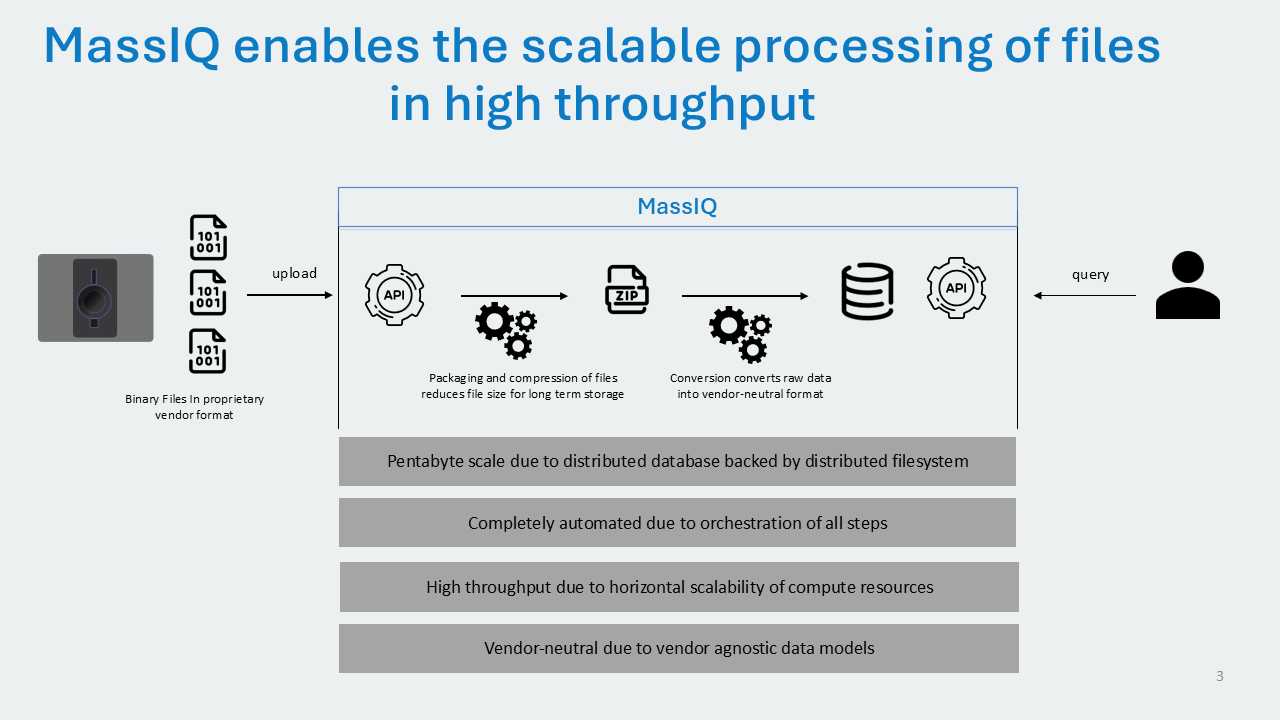

## Download demo data (if you have no own data)

We are now going to upload the actual data acquisitions to the massIQ AP.

For demonstration purposes we use a publicly avilable dataset which is available at https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD022622

In order to upload these data files to the API, we frist download these data files to the local machine. From there we will upload it.



In [ ]:
# Connect to FTP server
ftp = FTP("ftp.pride.ebi.ac.uk")
ftp.login()  # anonymous login: ftp.login()

# Navigate to directory (if needed)
ftp.cwd("pride/data/archive/2021/09/PXD022622")


# Returns a list of file and directory names
files = ftp.nlst()
print(files)


ftp.quit()

filtered_files = [file for file in files if re.match(".*.wiff$|.*.wiff.scan$",file)]

def download_file_to_local(host,path,file_name):
  ftp = FTP(host)
  ftp.login()  # anonymous login: ftp.login()

  # Navigate to directory (if needed)
  ftp.cwd(path)

  with open(file_name,"wb") as f:

      def write_to_file(data):
        f.write(data)

      ftp.retrbinary(f"RETR {file_name}",write_to_file)

  ftp.quit()

file_range = list(range(0, len(filtered_files), 10))

file_range.append(len(filtered_files))

for ind in range(len(file_range) - 1):

  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:

    futures = [executor.submit(download_file_to_local,"ftp.pride.ebi.ac.uk","pride/data/archive/2021/09/PXD022622" , file) for file in filtered_files[file_range[ind]:file_range[ind + 1]]]

    concurrent.futures.wait(futures)



['Coryne190506.group', 'Coryne190506.mgf', 'CorynemanualDB200320.txt', 'Proteom1.1.1.wiff', 'Proteom1.1.1.wiff.1.idx2', 'Proteom1.1.1.wiff.scan', 'Proteom1.1.2.wiff', 'Proteom1.1.2.wiff.1.idx2', 'Proteom1.1.2.wiff.scan', 'Proteom1.1.3.wiff', 'Proteom1.1.3.wiff.1.idx2', 'Proteom1.1.3.wiff.scan', 'Proteom1.1.4.wiff', 'Proteom1.1.4.wiff.1.idx2', 'Proteom1.1.4.wiff.scan', 'Proteom1.1.5.wiff', 'Proteom1.1.5.wiff.1.idx2', 'Proteom1.1.5.wiff.scan', 'Proteom1.2.1.wiff', 'Proteom1.2.1.wiff.1.idx2', 'Proteom1.2.1.wiff.scan', 'Proteom1.2.2.wiff', 'Proteom1.2.2.wiff.1.idx2', 'Proteom1.2.2.wiff.scan', 'Proteom1.2.3.wiff', 'Proteom1.2.3.wiff.1.idx2', 'Proteom1.2.3.wiff.scan', 'Proteom1.2.4.wiff', 'Proteom1.2.4.wiff.1.idx2', 'Proteom1.2.4.wiff.scan', 'Proteom1.2.5.wiff', 'Proteom1.2.5.wiff.1.idx2', 'Proteom1.2.5.wiff.scan', 'Proteom1.3.1.wiff', 'Proteom1.3.1.wiff.1.idx2', 'Proteom1.3.1.wiff.scan', 'Proteom1.3.2.wiff', 'Proteom1.3.2.wiff.1.idx2', 'Proteom1.3.2.wiff.scan', 'Proteom1.3.3.wiff', 'Proteom

## Upload Source Files to the API

Now that we have a proteome database, we can start uploading data and evaluate those data with the proteome database. The raw data files are also referred to as "source_files.

Using the 'upload_source_files' function, we can upload all files of a given folder to a given target directory. The first argument of this function is the local directory from which to fetch the files. The second argument specifies the remote path to where the files shall be uploaded. The files will be uploaded to this location under their filename in the local filesystem. Again, it must be a relative POSIX path. As described above you can use characters, numbers, dashes, and underscores in each segment of the path.

In [ ]:

local_path = Path(os.getcwd()).absolute().resolve()

client.upload_source_files(local_path,"My/remote/path")

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom6.5.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.2.5.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom2.4.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.2.5.wiff

Up

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.2.5.wiff

Successfully uploaded file /content/Proteom4.4.2.wiff

Successfully uploaded file /content/Proteom5.2.5.wiff

Successfully uploaded file /content/Proteom6.5.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom8.5.4.wiff.scan

Successfully uploaded file /content/Proteom2.4.2.wiff.scan

Successfully uploaded file /content/Proteom4.5.2.wiff.scan

Successfully uploaded file /content/Proteom1.1.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.4.1.wiff

Uploading file with absolute path /content/Proteom2.1.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.1.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defin

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom3.4.1.wiff

Successfully uploaded file /content/Proteom2.1.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom6.4.1.wiff.scan

Successfully uploaded file /content/Proteom3.4.2.wiff.scan

Successfully uploaded file /content/Proteom3.2.5.wiff.scan

Successfully uploaded file /content/Proteom5.5.1.wiff.scan

Successfully uploaded file /content/Proteom5.3.1.wiff.scan

Successfully uploaded file /content/Proteom3.1.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.4.wiff.scan

Uploading file with absolute path /content/Proteom5.4.2.wiff

Uploading file with absolute path /content/Proteom3.4.1.wiff.sca

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom7.4.5.wiff

Successfully uploaded file /content/Proteom8.4.5.wiff

Successfully uploaded file /content/Proteom5.4.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom3.3.2.wiff.scan

Successfully uploaded file /content/Proteom1.3.5.wiff.scan

Successfully uploaded file /content/Proteom3.4.1.wiff.scan

Successfully uploaded file /content/Proteom3.2.4.wiff.scan

Successfully uploaded file /content/Proteom3.3.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.3.4.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom2.1.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom5.3.4.wiff

Successfully uploaded file /content/Proteom1.1.1.wiff

Successfully uploaded file /content/Proteom6.4.1.wiff

Successfully uploaded file /content/Proteom8.2.4.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom8.2.4.wiff.scan

Successfully uploaded file /content/Proteom2.1.2.wiff.scan

Successfully uploaded file /content/Proteom5.1.1.wiff.scan

Successfully uploaded file /content/Proteom6.2.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.1.1.wiff

Uploading file with absolute path /content/Proteom2.1.4.wiff.scan

Uploading file with absolute path /content/Proteom6.4.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.4.3.wiff

Successfully uploaded file /content/Proteom2.2.4.wiff

Successfully uploaded file /content/Proteom7.5.4.wiff

Successfully uploaded file /content/Proteom3.1.1.wiff

Successfully uploaded file /content/Proteom4.5.2.wiff

Successfully uploaded file /content/Proteom7.3.1.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom6.4.2.wiff.scan

Successfully uploaded file /content/Proteom2.1.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.5.5.wiff.scan

Uploading file with absolute path /content/Proteom1.2.5.wiff.scan

Uploading file with absolute path /content/Proteom2.4.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom4.5.4.wiff.scan

Uploading file u

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom5.4.4.wiff

Successfully uploaded file /content/Proteom6.5.3.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom4.5.4.wiff.scan

Successfully uploaded file /content/Proteom1.2.5.wiff.scan

Successfully uploaded file /content/Proteom6.5.4.wiff.scan

Successfully uploaded file /content/Proteom3.4.4.wiff.scan

Successfully uploaded file /content/Proteom2.4.4.wiff.scan

Successfully uploaded file /content/Proteom3.5.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom8.1.5.wiff

Uploading file with absolute path /content/Proteom7.2.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom4.1.4.wiff.sca

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.4.4.wiff

Successfully uploaded file /content/Proteom5.5.3.wiff

Successfully uploaded file /content/Proteom2.1.4.wiff

Successfully uploaded file /content/Proteom8.1.5.wiff

Successfully uploaded file /content/Proteom4.1.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom3.2.1.wiff.scan

Successfully uploaded file /content/Proteom4.1.4.wiff.scan

Successfully uploaded file /content/Proteom7.2.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.1.5.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading fil

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom1.5.4.wiff

Successfully uploaded file /content/Proteom4.1.5.wiff

Successfully uploaded file /content/Proteom2.5.2.wiff

Successfully uploaded file /content/Proteom8.3.1.wiff

Successfully uploaded file /content/Proteom7.1.5.wiff

Successfully uploaded file /content/Proteom7.2.1.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom2.2.5.wiff.scan

Successfully uploaded file /content/Proteom4.4.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.1.5.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom2.4.5.wiff.scan

Uploading file with absolute path /content/Proteom5.3.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom8.2.1.wiff.scan

Uploading file using 

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom5.5.2.wiff

Successfully uploaded file /content/Proteom2.5.1.wiff

Successfully uploaded file /content/Proteom1.1.5.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom2.4.3.wiff.scan

Successfully uploaded file /content/Proteom2.4.5.wiff.scan

Successfully uploaded file /content/Proteom8.2.1.wiff.scan

Successfully uploaded file /content/Proteom2.1.3.wiff.scan

Successfully uploaded file /content/Proteom5.3.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.1.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.5.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom2.4.2.wiff

Successfully uploaded file /content/Proteom7.1.1.wiff

Successfully uploaded file /content/Proteom3.2.2.wiff

Successfully uploaded file /content/Proteom1.1.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.5.1.wiff.scan

Successfully uploaded file /content/Proteom6.1.5.wiff.scan

Successfully uploaded file /content/Proteom6.3.4.wiff.scan

Successfully uploaded file /content/Proteom3.3.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.4.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.4.5.wiff.scan

Uploading file using the follo

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom2.2.1.wiff

Successfully uploaded file /content/Proteom1.1.4.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom8.2.2.wiff.scan

Successfully uploaded file /content/Proteom5.4.4.wiff.scan

Successfully uploaded file /content/Proteom2.1.1.wiff.scan

Successfully uploaded file /content/Proteom5.1.4.wiff.scan

Successfully uploaded file /content/Proteom7.4.5.wiff.scan

Successfully uploaded file /content/Proteom4.3.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.5.3.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=M

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom1.5.3.wiff

Successfully uploaded file /content/Proteom8.3.4.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom5.4.1.wiff.scan

Successfully uploaded file /content/Proteom4.4.5.wiff.scan

Successfully uploaded file /content/Proteom6.4.3.wiff.scan

Successfully uploaded file /content/Proteom1.1.2.wiff.scan

Successfully uploaded file /content/Proteom7.1.4.wiff.scan

Successfully uploaded file /content/Proteom6.1.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom4.1.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.4.3.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.1.wiff.sca

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom1.4.3.wiff

Successfully uploaded file /content/Proteom1.5.2.wiff

Successfully uploaded file /content/Proteom6.4.5.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom3.3.1.wiff.scan

Successfully uploaded file /content/Proteom1.2.1.wiff.scan

Successfully uploaded file /content/Proteom4.1.5.wiff.scan

Successfully uploaded file /content/Proteom8.4.2.wiff.scan

Successfully uploaded file /content/Proteom8.4.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.4.5.wiff

Uploading file with absolute path /content/Proteom2.5.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom6.3.5.wiff.scan

Uploading file using the following url: https://ibt078.ma

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom8.3.2.wiff

Successfully uploaded file /content/Proteom5.4.5.wiff

Successfully uploaded file /content/Proteom4.4.1.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom6.5.1.wiff.scan

Successfully uploaded file /content/Proteom2.5.3.wiff.scan

Successfully uploaded file /content/Proteom6.1.4.wiff.scan

Successfully uploaded file /content/Proteom5.5.3.wiff.scan

Successfully uploaded file /content/Proteom6.3.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.3.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.2.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_de

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom2.3.3.wiff

Successfully uploaded file /content/Proteom1.5.1.wiff

Successfully uploaded file /content/Proteom2.3.4.wiff

Successfully uploaded file /content/Proteom3.1.5.wiff

Successfully uploaded file /content/Proteom1.2.3.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom3.2.3.wiff.scan

Successfully uploaded file /content/Proteom1.4.4.wiff.scan

Successfully uploaded file /content/Proteom5.3.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom2.3.1.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.4.1.wiff.scan

Uploading file with absolute path /content/Proteom4.5.4.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom6.5.4.wiff

Successfully uploaded file /content/Proteom2.3.1.wiff

Successfully uploaded file /content/Proteom4.3.5.wiff

Successfully uploaded file /content/Proteom4.5.4.wiff

Successfully uploaded file /content/Proteom5.2.2.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom5.4.5.wiff.scan

Successfully uploaded file /content/Proteom1.3.2.wiff.scan

Successfully uploaded file /content/Proteom1.4.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom8.3.5.wiff

Uploading file with absolute path /content/Proteom5.4.3.wiff

Uploading file with absolute path /content/Proteom3.2.4.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /con

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom8.3.5.wiff

Successfully uploaded file /content/Proteom3.2.4.wiff

Successfully uploaded file /content/Proteom6.1.4.wiff

Successfully uploaded file /content/Proteom5.4.3.wiff

Successfully uploaded file /content/Proteom7.1.2.wiff

Successfully uploaded file /content/Proteom2.5.4.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom4.1.1.wiff.scan

Successfully uploaded file /content/Proteom8.5.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.5.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.5.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.2.4.wiff.scan

Uploading file using 

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom7.2.3.wiff

Successfully uploaded file /content/Proteom3.3.5.wiff

Successfully uploaded file /content/Proteom4.1.3.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom3.3.3.wiff.scan

Successfully uploaded file /content/Proteom1.1.4.wiff.scan

Successfully uploaded file /content/Proteom1.1.1.wiff.scan

Successfully uploaded file /content/Proteom1.2.4.wiff.scan

Successfully uploaded file /content/Proteom1.5.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.4.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.3.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.3.2.wiff

Uploading file using the following url: https://ibt078.massflows.de

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom3.1.4.wiff

Successfully uploaded file /content/Proteom3.3.3.wiff

Successfully uploaded file /content/Proteom4.4.3.wiff

Successfully uploaded file /content/Proteom7.4.2.wiff

Successfully uploaded file /content/Proteom3.2.3.wiff

Successfully uploaded file /content/Proteom1.3.2.wiff

Successfully uploaded file /content/Proteom8.4.2.wiff

Successfully uploaded file /content/Proteom3.1.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.2.4.wiff.scan

Uploading file with absolute path /content/Proteom5.5.4.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_pat

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom8.2.3.wiff

Successfully uploaded file /content/Proteom5.5.4.wiff

Successfully uploaded file /content/Coryne_only_10_proteins_2.mzid



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.4.3.wiff.scan

Successfully uploaded file /content/Proteom5.1.5.wiff.scan

Successfully uploaded file /content/Proteom6.2.3.wiff.scan

Successfully uploaded file /content/Proteom4.5.1.wiff.scan

Successfully uploaded file /content/Proteom7.2.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.3.4.wiff.scan

Uploading file with absolute path /content/Proteom2.2.1.wiff.scan

Uploading file with absolute path /content/Proteom4.2.4.wiff.scan

Uploading file using the following url: https://ibt0

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom1.5.5.wiff

Successfully uploaded file /content/Proteom2.1.3.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.1.2.wiff.scan

Successfully uploaded file /content/Proteom5.3.4.wiff.scan

Successfully uploaded file /content/Proteom2.2.1.wiff.scan

Successfully uploaded file /content/Proteom4.2.5.wiff.scan

Successfully uploaded file /content/Proteom4.2.4.wiff.scan

Successfully uploaded file /content/Proteom7.4.4.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.2.5.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.1.1.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.3.1.wiff

Uploadi

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom5.1.1.wiff

Successfully uploaded file /content/Proteom1.2.5.wiff

Successfully uploaded file /content/Proteom8.5.5.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom3.3.1.wiff

Successfully uploaded file /content/Proteom3.1.3.wiff

Successfully uploaded file /content/Proteom2.4.4.wiff

Successfully uploaded file /content/Proteom7.4.1.wiff

Successfully uploaded file /content/Proteom8.3.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom2.4.1.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.4.3.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom1.2.4.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom7.3.3.wiff

Successfully uploaded file /content/Proteom4.2.5.wiff

Successfully uploaded file /content/Proteom6.5.5.wiff

Successfully uploaded file /content/Proteom1.2.4.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom2.4.1.wiff.scan

Successfully uploaded file /content/Proteom7.1.1.wiff.scan

Successfully uploaded file /content/Proteom1.4.3.wiff.scan

Successfully uploaded file /content/Proteom5.3.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom8.3.3.wiff

Uploading file with absolute path /content/Proteom2.3.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom5.5.1.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_pa

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom2.3.2.wiff

Successfully uploaded file /content/Proteom5.5.1.wiff

Successfully uploaded file /content/Proteom8.3.3.wiff

Successfully uploaded file /content/Proteom2.2.3.wiff

Successfully uploaded file /content/Proteom1.3.1.wiff

Successfully uploaded file /content/Proteom6.1.5.wiff

Successfully uploaded file /content/Proteom2.3.5.wiff

Successfully uploaded file /content/Proteom5.3.2.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom4.4.2.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Pro

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom6.1.3.wiff

Successfully uploaded file /content/Proteom3.2.1.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom4.4.2.wiff.scan

Successfully uploaded file /content/Proteom6.5.2.wiff.scan

Successfully uploaded file /content/Proteom7.5.5.wiff.scan

Successfully uploaded file /content/Proteom6.5.5.wiff.scan

Successfully uploaded file /content/Proteom5.2.5.wiff.scan

Successfully uploaded file /content/Proteom8.4.5.wiff.scan

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom7.1.3.wiff

Uploading file using the following url: https://ibt078.massflows.de:30007/api/v1/upload/files/batch/sourcefiles?user_defined_path=My%2Fremote%2Fpath
Uploading file with absolute path /content/Proteom3.5.3.wiff.scan

Uploading file with absolute path /content/Proteom1.4.1.wiff

Up

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connect

Successfully uploaded file /content/Proteom1.4.1.wiff

Successfully uploaded file /content/Proteom5.3.1.wiff

Successfully uploaded file /content/Proteom7.5.1.wiff

Successfully uploaded file /content/Proteom7.1.3.wiff

Successfully uploaded file /content/Proteom6.3.5.wiff



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully uploaded file /content/Proteom3.5.3.wiff.scan



KeyboardInterrupt: 

## Information about uploaded files

If you want to retrieve information about the files just uploaded, you can use the /sourcefiles endpoint as shown below.

You will see your specified path at upload time under the property 'user_defined_path'. Additionally, file size, ownership etc. is displayed.

In case of wiff files, two files (wiff and wiff.scan) are matches and packaged together into one 'archive'. Both wiff and wiff.scan files are with the same 'filename' attribute are merged into one 'archive'.

When a file has been logically grouped with another file into an archive, the column "archive_id" will show the id of the archive.

In [ ]:
import pandas as pd
import requests

response_get_sourcefiles = requests.get(
    f"{client.config.base_url}/sourcefiles/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

pd.DataFrame(response_get_sourcefiles.json()).sort_values(by = "filename", ascending=False)

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,owner_id,filename,absolute_path,type,permission,acl,uploaded_by_id,file_size,processing_in_progress,user_defined_path,owner,filename_extension,upload_finished,processed,archive_id,id
166,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,None,33b4475f-2cec-47f7-b17e-fe71db366f64
3,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.4,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,400606560,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,None,89398300-5218-4eed-8d85-05b7e9e3a9a1
134,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,389184696,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,None,dd4de4f8-9718-426a-a162-2222fecbdef1
13,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.4.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,8b082916-d7ac-4103-9f4d-72172e096dc3,bedea2ac-3120-4414-8ff7-c26481732221
183,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.4.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,441525676,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,8b082916-d7ac-4103-9f4d-72172e096dc3,59518228-c484-4689-ba8f-e7efbf09acdd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.2,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,387399108,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,735a9f5a-f77e-47d5-bb14-628d7a5a81b5,aed0a2fe-bc9d-4f9b-aa53-44b261bdc7f6
72,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.2,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,735a9f5a-f77e-47d5-bb14-628d7a5a81b5,5ea284ba-8f09-453c-bc95-f55d6c83100a
131,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,384965140,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,ee36141c-52e3-4518-8585-2299c38de63c,d041b0ae-42e7-4ab4-9614-939ca20ec327
42,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,ee36141c-52e3-4518-8585-2299c38de63c,b4ce3622-8ee6-4d81-9f25-1a3acbb0e9c8


## See matched sourced file as archives

The pipelne which works behind the scenes takes some seconds in order to find corresponding wiff and wiff.scan files. Once it found matching files, it will package them together and compress them (in order to save storage costs). For each such package you will find an entry in the /archives endpoint as shown below[Linktext](https://)

In [ ]:
import pandas as pd

response_get_archives = requests.get(
    f"{client.config.base_url}/archives/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

pd.DataFrame(response_get_sourcefiles.json()).sort_values(by = "filename", ascending=False)



/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,owner_id,filename,absolute_path,type,permission,acl,uploaded_by_id,file_size,processing_in_progress,user_defined_path,owner,filename_extension,upload_finished,processed,archive_id,id
166,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,None,33b4475f-2cec-47f7-b17e-fe71db366f64
3,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.4,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,400606560,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,None,89398300-5218-4eed-8d85-05b7e9e3a9a1
134,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.5.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,389184696,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,None,dd4de4f8-9718-426a-a162-2222fecbdef1
13,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.4.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,8b082916-d7ac-4103-9f4d-72172e096dc3,bedea2ac-3120-4414-8ff7-c26481732221
183,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.4.5,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,441525676,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,8b082916-d7ac-4103-9f4d-72172e096dc3,59518228-c484-4689-ba8f-e7efbf09acdd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.2,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,387399108,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,735a9f5a-f77e-47d5-bb14-628d7a5a81b5,aed0a2fe-bc9d-4f9b-aa53-44b261bdc7f6
72,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.2,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,735a9f5a-f77e-47d5-bb14-628d7a5a81b5,5ea284ba-8f09-453c-bc95-f55d6c83100a
131,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,384965140,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff.scan,True,False,ee36141c-52e3-4518-8585-2299c38de63c,d041b0ae-42e7-4ab4-9614-939ca20ec327
42,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.1,/sourcefiles/a5524ef6-c76d-49c2-9fee-a4c5b167d...,WIFF,None,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,9011200,False,My/remote/path/,jannick.kappelmann@massflows.de,wiff,True,False,ee36141c-52e3-4518-8585-2299c38de63c,b4ce3622-8ee6-4d81-9f25-1a3acbb0e9c8


## See Batches

In order to better organize archives so that you don't have one gigantic list of archives, they are organized into batches. All files in one folder belong one batch. Hence, the batch name is identical to the folder name. As we just uploaded to one folder in the previous step we just see one batch here.

In [ ]:


batches = requests.get(
    f"{client.config.base_url}/batches/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

batch_df=pd.DataFrame(batches.json())
batch_df


Token request successful


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,owner,frozen,description,owner_id,added_by_id,updated_by_id,name,update_time,id,create_time
0,jannick.kappelmann@massflows.de,False,None,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,None,My/remote/path/,None,faf393a0-3511-4d9f-8ad3-25b28090ffbe,None


## Get Archives of one batch

Using the 'id' property of the batch you can access all archives of the batch. Please have a look at the meta information about each archive. The processing of High resolution data may take some time as the files are very large.



In [ ]:
archives_of_batch = requests.get(
    f"{client.config.base_url}/batches/{batch_df.iloc[0,:]['id']}/archives",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

pd.DataFrame(archives_of_batch.json())

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,permission,updated_at,processing_in_progress,owner_id,id,owner,batch_id,updated_by_id,uploaded_at,user_defined_path,file_size,upload_finished,filename_extension,uploaded_by_id,filename,type,absolute_path,acl,processed
0,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,bcf03742-1599-4b3d-b52d-e3f005b4966e,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,224277227,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom4.5.2,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,True
1,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,57f2d0ea-bab1-4754-8d23-e265c04b48bf,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,221205521,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom5.4.5,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
2,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,23ff00c1-4c50-49a6-86bc-cf51ae9362db,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,227791584,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom8.2.4,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
3,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,f9d21acf-6afd-4fa4-8eac-aa4fb8637aba,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,238917106,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom2.1.4,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,True
4,None,None,True,a5524ef6-c76d-49c2-9fee-a4c5b167d327,735a9f5a-f77e-47d5-bb14-628d7a5a81b5,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,226607069,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom1.1.2,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
5,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,80dd4d39-c0d7-463e-a05f-6e5872e7ce1e,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,220442633,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom6.4.1,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
6,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,d33d5113-7e9b-46f3-8099-f8eb56d77a77,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,218649527,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom2.4.2,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
7,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,7d7e503d-cbc4-46cb-8192-54c31e5a4388,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,215229985,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom5.4.4,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
8,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,d3e4f7a6-ca67-41d2-a0b5-044253bf6324,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,237248371,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom7.4.5,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False
9,None,None,False,a5524ef6-c76d-49c2-9fee-a4c5b167d327,4724acc5-e669-4731-88e6-d8b5c93be7c2,jannick.kappelmann@massflows.de,faf393a0-3511-4d9f-8ad3-25b28090ffbe,a5524ef6-c76d-49c2-9fee-a4c5b167d327,None,My/remote/path/,222473767,True,wiff.tar.gz,a5524ef6-c76d-49c2-9fee-a4c5b167d327,Proteom4.4.1,WIFF,/compressed/a5524ef6-c76d-49c2-9fee-a4c5b167d3...,None,False


## Get Acquisitons of this batch

Each archive is then opened, mass spectra are extracted and stored such that you access them via the API. One data file (equivalent to one archive) may contain several acquisitions (which contain the actual data).

You can see the measured acquisitons from all archives of a batch by using the 'batches/\<batch_id>/acquisitions

endpoint




In [ ]:

response_get_acquisitions = requests.get(
    f"{client.config.base_url}/batches/{batch_df.iloc[0,:]['id']}/acquisitions/",
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

acquisitions_of_batch=response_get_acquisitions.json()
acquisitions_of_batch


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'id': '61c9593f-639f-4281-9123-ea53b6fcb8ca',
  'archive_id': 'bcf03742-1599-4b3d-b52d-e3f005b4966e',
  'name': 'Proteom4.5.2-Proteom 4.5 151006 JK',
  'mzmlid': 'Proteom4.5.2-Proteom 4.5 151006 JK',
  'processed': True,
  'processing_in_progress': False,
  'owner_id': 'a5524ef6-c76d-49c2-9fee-a4c5b167d327',
  'batch_id': 'faf393a0-3511-4d9f-8ad3-25b28090ffbe',
  'data_reference': {'batch_id': 'faf393a0-3511-4d9f-8ad3-25b28090ffbe',
   'acquisition_id': '61c9593f-639f-4281-9123-ea53b6fcb8ca'}},
 {'id': '2a55f377-46de-4e05-a54b-425c90350fc2',
  'archive_id': 'f9d21acf-6afd-4fa4-8eac-aa4fb8637aba',
  'name': 'Proteom2.1.4-Proteom 2.1 151006 JK',
  'mzmlid': 'Proteom2.1.4-Proteom 2.1 151006 JK',
  'processed': True,
  'processing_in_progress': False,
  'owner_id': 'a5524ef6-c76d-49c2-9fee-a4c5b167d327',
  'batch_id': 'faf393a0-3511-4d9f-8ad3-25b28090ffbe',
  'data_reference': {'batch_id': 'faf393a0-3511-4d9f-8ad3-25b28090ffbe',
   'acquisition_id': '2a55f377-46de-4e05-a54b-425c90350fc2'

## Access data


**How to access the data**

Before continuing, we must clarify how we can identify a particular acquisiton in order for us to be able to retrieve detailed information about it. One acquisition, which is the elemental entity that corresponds to one instrument run, we need a so called *data reference* which is a pointer to an acquisition within all the data stored in the system.

The acquisitions endpoint from above has a field 'data_reference' This field can be used to access all data of the acquisition.

**Acquisition Metadata**


Before accessing the actual m/z intensity values, you need to know something about the acquisiton. What was the acquisiton mode? (you cannot extract MS2 EIC from an MS1 acquisiton), what isolation windows were actually measured?

The below command retrieves the metadata from the first acquistion of the batch.

In [ ]:


acquisition_meta_data = requests.post(
    f"{client.config.base_url}/data/metadata/",
    data= json.dumps(acquisitions_of_batch[0]["data_reference"]),
    headers={"Authorization": f"Bearer {client.config.access_token}"},
    verify=False
)

metadata_data_of_acquisition = acquisition_meta_data.json()
metadata_data_of_acquisition

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'acquisitionName': 'Proteom2.5.5-Proteom 2.5 151006 JK',
 'sourceFiles': ['Proteom2.5.5.wiff', 'Proteom2.5.5.wiff.scan'],
 'polarityCount': [{'polarity': 'POSITIVE', 'count': 85156}],
 'acquisitionStart': 1454782388000,
 'softwareVersion': 'unknown',
 'acquisitionMode': 'SWATH',
 'instrumentSerialNumber': 'BR20551410',
 'msLevelCount': [{'mslevel': 1, 'count': 2076},
  {'mslevel': 2, 'count': 83080}],
 'isolationWindowCount': [{'count': 2077,
   'window': {'isolationWindowLowerEnd': 320.1,
    'isolationWindowUpperEnd': 331.6,
    'lowerOffset': 5.75,
    'upperOffset': 5.75,
    'width': 11.5,
    'isolationWindowTarget': 325.85,
    'experiment': 11}},
  {'count': 2077,
   'window': {'isolationWindowLowerEnd': 401.29999999999995,
    'isolationWindowUpperEnd': 413.5,
    'lowerOffset': 6.1,
    'upperOffset': 6.1,
    'width': 12.2,
    'isolationWindowTarget': 407.4,
    'experiment': 19}},
  {'count': 2077,
   'window': {'isolationWindowLowerEnd': 770.9,
    'isolationWindowUpperE

## Inspecting the metadata

We can see that the metadata endpoint delivers infromation about:  

*   The acquisition method
*   How many scans are performed
*   which isolation windows


## Getting Extracted Ion Traces

WIth this information we can craft our request for the actual data because now we know what we can actually extract. The below example shows how to retrieve an ion trace from a MS2 spectrum of an isolation windows. The body of the request codes all information that is needd to extract an ion trace from an MS2 spectrum.

In [ ]:


isolation_window= metadata_data_of_acquisition["isolationWindowCount"][0]["window"]



mzfilter = {
                  "type": "mz-interval",
                  "value":
                                {
                                            "startMz":115.9,
                                            "endMz":116.1
                                }
                }


ic_selector = {
        "name": "test-trace",
        "filter": {1: isolation_window, 2: mzfilter}
    }


request = {
          "ic_selectors": [ic_selector],
          "data_references": [acquisitions_of_batch[0]["data_reference"]],
          "schema_version": "v2"
        }


r = requests.post(
        f"{client.config.base_url}/data/ion-chromatograms/by-isolation-window",
        json=request,
        verify=False
    )

r.json()






/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ibt078.massflows.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'ic_results': [{'data_reference': {'batch_id': 'ca29dc22-2f20-42c9-a38c-f46cd16f3d03',
    'acquisition_id': '562d7a83-1e8c-4c95-81ea-9b863d6fda43'},
   'ics': [{'dataArray': {'time': [759.0,
       3365.0,
       5965.0,
       8565.0,
       11165.0,
       13765.0,
       16365.0,
       18964.0,
       21564.0,
       24164.0,
       26764.0,
       29364.0,
       31964.0,
       34563.0,
       37163.0,
       39763.0,
       42363.0,
       44963.0,
       47562.0,
       50162.0,
       52762.0,
       55362.0,
       57962.0,
       60562.0,
       63161.0,
       65761.0,
       68361.0,
       70961.0,
       73561.0,
       76161.0,
       78760.0,
       81360.0,
       83960.0,
       86560.0,
       89160.0,
       91759.0,
       94359.0,
       96959.0,
       99559.0,
       102159.0,
       104759.0,
       107358.0,
       109958.0,
       112558.0,
       115158.0,
       117758.0,
       120358.0,
       122957.0,
       125557.0,
       128157.0,
       130757.0